## Optimization for Fully Connected Networks

In this notebook, we will implement different optimization rules for gradient descent.  We have provided starter code; however, you will need to copy and paste your code from your implementation of the modular fully connected nets in HW #3 to build upon this.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [17]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Building upon your HW #3 implementation

Copy and paste the following functions from your HW #3 implementation of a modular FC net:

- `affine_forward` in `nndl/layers.py`
- `affine_backward` in `nndl/layers.py`
- `relu_forward` in `nndl/layers.py`
- `relu_backward` in `nndl/layers.py`
- `affine_relu_forward` in ``nndl/layer_utils.py``
- `affine_relu_backward` in ``nndl/layer_utils.py``
- The `FullyConnectedNet` class in `nndl/fc_net.py`

### Test all functions you copy and pasted

In [19]:
from nndl.layer_tests import *

affine_forward_test(); print('\n')
affine_backward_test(); print('\n')
relu_forward_test(); print('\n')
relu_backward_test(); print('\n')
affine_relu_test(); print('\n')
fc_net_test()

If affine_forward function is working, difference should be less than 1e-9:
difference: 9.769849468192957e-10


If affine_backward is working, error should be less than 1e-9::
dx error: 3.3294055798277563e-10
dw error: 4.49861745293341e-11
db error: 1.554638452499184e-11


If relu_forward function is working, difference should be around 1e-8:
difference: 4.999999798022158e-08


If relu_forward function is working, error should be less than 1e-9:
dx error: 3.275605388806931e-12


If affine_relu_forward and affine_relu_backward are working, error should be less than 1e-9::
dx error: 1.1220504182289867e-09
dw error: 3.4433399428004154e-10
db error: 1.825267882945388e-11


Running check with reg = 0
Initial loss: 2.302843502965483
W1 relative error: 9.758605929470631e-07
W2 relative error: 2.6507832027517302e-06
W3 relative error: 6.841637118247668e-07
b1 relative error: 8.419269908098567e-09
b2 relative error: 3.34327626837078e-09
b3 relative error: 1.4827426828919928e-10
Running check wi

# Training a larger model

In general, proceeding with vanilla stochastic gradient descent to optimize models may be fraught with problems and limitations, as discussed in class.  Thus, we implement optimizers that improve on SGD.

## SGD + momentum

In the following section, implement SGD with momentum.  Read the `nndl/optim.py` API, which is provided by CS231n, and be sure you understand it.  After, implement `sgd_momentum` in `nndl/optim.py`.  Test your implementation of `sgd_momentum` by running the cell below.

In [20]:
from nndl.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: {}'.format(rel_error(next_w, expected_next_w)))
print('velocity error: {}'.format(rel_error(expected_velocity, config['velocity'])))

next_w error: 8.882347033505819e-09
velocity error: 4.269287743278663e-09


## SGD + Nesterov momentum
Implement `sgd_nesterov_momentum` in `ndl/optim.py`.

In [21]:
from nndl.optim import sgd_nesterov_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_nesterov_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [0.08714,      0.15246105,  0.21778211,  0.28310316,  0.34842421],
  [0.41374526,   0.47906632,  0.54438737,  0.60970842,  0.67502947],
  [0.74035053,   0.80567158,  0.87099263,  0.93631368,  1.00163474],
  [1.06695579,   1.13227684,  1.19759789,  1.26291895,  1.32824   ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579,  0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: {}'.format(rel_error(next_w, expected_next_w)))
print('velocity error: {}'.format(rel_error(expected_velocity, config['velocity'])))

next_w error: 1.0875186845081027e-08
velocity error: 4.269287743278663e-09


## Evaluating SGD, SGD+Momentum, and SGD+NesterovMomentum

Run the following cell to train a 6 layer FC net with SGD, SGD+momentum, and SGD+Nesterov momentum.  You should see that SGD+momentum achieves a better loss than SGD, and that SGD+Nesterov momentum achieves a slightly better loss (and training accuracy) than SGD+momentum.

Optimizing with sgd
Optimizing with sgd_momentum
Optimizing with sgd_nesterov_momentum


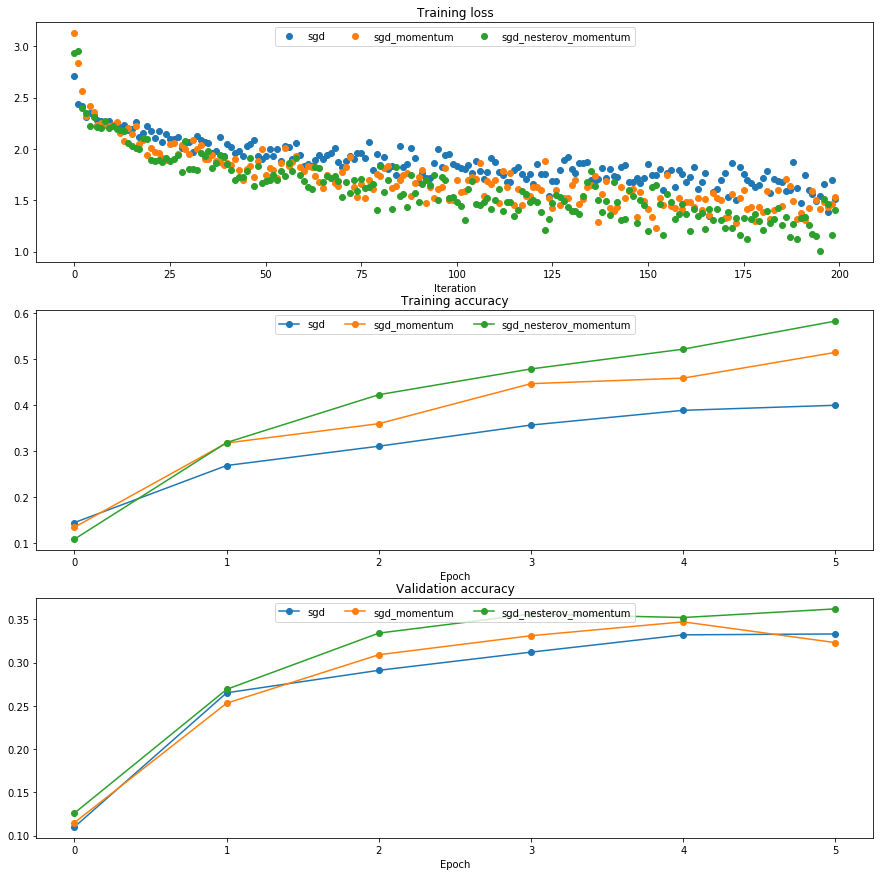

In [22]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum', 'sgd_nesterov_momentum']:
  print('Optimizing with {}'.format(update_rule))
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=False)
  solvers[update_rule] = solver
  solver.train()
  print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## RMSProp

Now we go to techniques that adapt the gradient.  Implement `rmsprop` in `nndl/optim.py`.  Test your implementation by running the cell below.

In [23]:
from nndl.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
a = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'a': a}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: {}'.format(rel_error(expected_next_w, next_w)))
print('cache error: {}'.format(rel_error(expected_cache, config['a'])))

next_w error: 9.524687511038133e-08
cache error: 2.6477955807156126e-09


## Adaptive moments

Now, implement `adam` in `nndl/optim.py`.  Test your implementation by running the cell below.

In [24]:
# Test Adam implementation; you should see errors around 1e-7 or less
from nndl.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
a = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'v': v, 'a': a, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_a = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_v = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: {}'.format(rel_error(expected_next_w, next_w)))
print('a error: {}'.format(rel_error(expected_a, config['a'])))
print('v error: {}'.format(rel_error(expected_v, config['v'])))

next_w error: 1.1395691798535431e-07
a error: 4.208314038113071e-09
v error: 4.214963193114416e-09


## Comparing SGD, SGD+NesterovMomentum, RMSProp, and Adam

The following code will compare optimization with SGD, Momentum, Nesterov Momentum, RMSProp and Adam.  In our code, we find that RMSProp, Adam, and SGD + Nesterov Momentum achieve approximately the same training error after a few training epochs.

Optimizing with adam
Optimizing with rmsprop


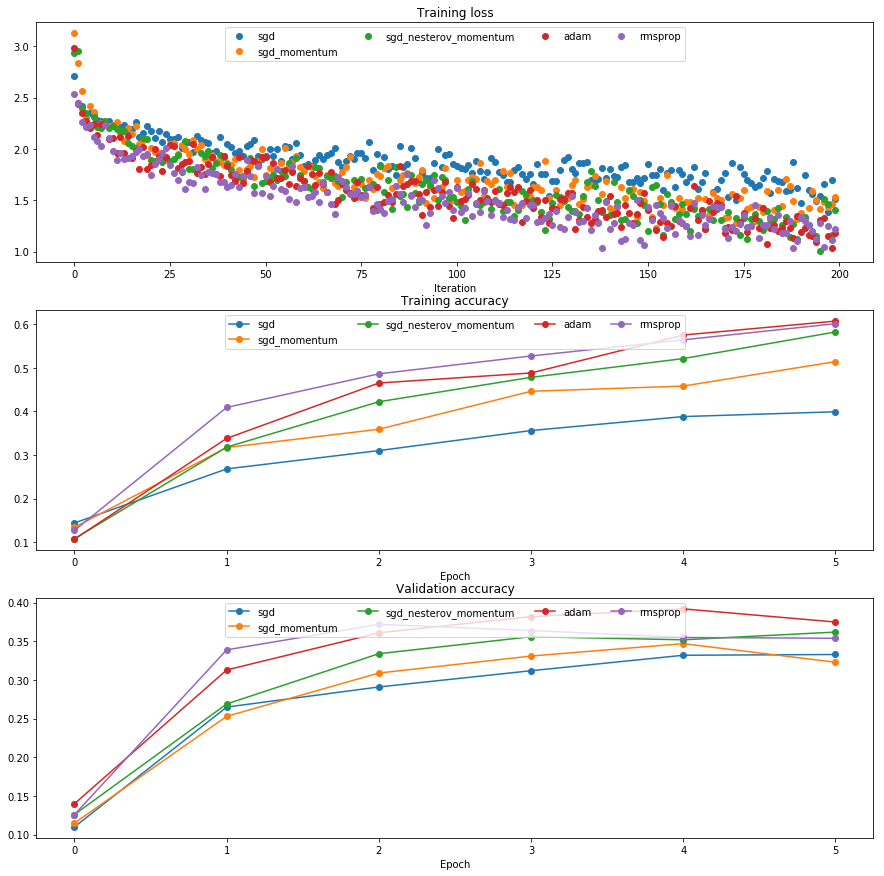

In [25]:
learning_rates = {'rmsprop': 2e-4, 'adam': 1e-3}

for update_rule in ['adam', 'rmsprop']:
  print('Optimizing with {}'.format(update_rule))
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=False)
  solvers[update_rule] = solver
  solver.train()
  print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Easier optimization

In the following cell, we'll train a 4 layer neural network having 500 units in each hidden layer with the different optimizers, and find that it is far easier to get up to 50+% performance on CIFAR-10.  After we implement batchnorm and dropout, we'll ask you to get 55+% on CIFAR-10.

In [26]:
optimizer = 'adam'
best_model = None

layer_dims = [500, 500, 500]
weight_scale = 0.01
learning_rate = 1e-3
lr_decay = 0.9

model = FullyConnectedNet(layer_dims, weight_scale=weight_scale,
                          use_batchnorm=True)

solver = Solver(model, data,
                num_epochs=10, batch_size=100,
                update_rule=optimizer,
                optim_config={
                  'learning_rate': learning_rate,
                },
                lr_decay=lr_decay,
                verbose=True, print_every=50)
solver.train()

(Iteration 1 / 4900) loss: 2.306725
(Epoch 0 / 10) train acc: 0.121000; val_acc: 0.148000
(Iteration 51 / 4900) loss: 1.801748
(Iteration 101 / 4900) loss: 1.589189
(Iteration 151 / 4900) loss: 1.939931
(Iteration 201 / 4900) loss: 1.679297
(Iteration 251 / 4900) loss: 1.735843
(Iteration 301 / 4900) loss: 1.549800
(Iteration 351 / 4900) loss: 1.739184
(Iteration 401 / 4900) loss: 1.721611
(Iteration 451 / 4900) loss: 1.674744
(Epoch 1 / 10) train acc: 0.451000; val_acc: 0.441000
(Iteration 501 / 4900) loss: 1.468856
(Iteration 551 / 4900) loss: 1.671042
(Iteration 601 / 4900) loss: 1.602160
(Iteration 651 / 4900) loss: 1.409814
(Iteration 701 / 4900) loss: 1.706334
(Iteration 751 / 4900) loss: 1.312938
(Iteration 801 / 4900) loss: 1.474955
(Iteration 851 / 4900) loss: 1.362951
(Iteration 901 / 4900) loss: 1.371373
(Iteration 951 / 4900) loss: 1.395546
(Epoch 2 / 10) train acc: 0.510000; val_acc: 0.444000
(Iteration 1001 / 4900) loss: 1.483582
(Iteration 1051 / 4900) loss: 1.224037
(It

In [27]:
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print('Validation set accuracy: {}'.format(np.mean(y_val_pred == data['y_val'])))
print('Test set accuracy: {}'.format(np.mean(y_test_pred == data['y_test'])))

Validation set accuracy: 0.549
Test set accuracy: 0.529
